In [1]:
import sys

sys.path.insert(0, '../')

import specutils
from specutils import analysis, manipulation, fitting
specutils

<module 'specutils' from '../specutils/__init__.py'>

In [2]:
from astropy.table import Table
from astropy.utils import data
from astropy.io import fits
from astropy import units as u
from astropy import constants as cnst
from astropy.modeling import models
import numpy as np

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

# Downloads/prep

## SDSS Spectra

First lets grab a few example spectra from the SDSS.  These are fairly typical lowish resolution stellar spectra. We start by getting a convenient list of known nearish K/M-type stars.

In [4]:
sdss_qry = """
SELECT z, ra, dec, sourceType, targetType, secTarget, fiberID, plate, mjd, specObjID, bestObjID, fluxObjID, targetObjID, plateID, sn1_r, sn2_r, spectroFlux_r, subClass 
FROM specObj 
WHERE ancillary_target1 & dbo.fAncillaryTarget1('RED_KG') > 0 
"""

t = Table.read('red_kgs_eteq.csv')
t['avg_sn'] = (t['sn1_r'] + t['sn2_r'])/2
t.sort('avg_sn')
t.reverse()
t['spectype'] = [sc.split('(')[0].strip() for sc in t['subClass']]
t['lumclass'] = [''.join([char for char in st[2:] if char.isupper()]) for st in t['spectype']]
giants = t['lumclass'] == 'III'
np.sum(giants)

334

Now download a couple of giants chosen to span the S/N range of this sample.

In [5]:
templ_spec_path = 'https://dr16.sdss.org/optical/spectrum/view/data/format=fits/spec=lite?plateid={plate}&mjd={mjd}&fiberid={fiberID}'

../specutils/io/default_loaders/sdss.py:80: RuntimeWarning: divide by zero encountered in true_divide
  stdev = np.sqrt(1.0/hdulist[1].data['ivar'])


('K4III', <Quantity 87.08272388 km / s>)

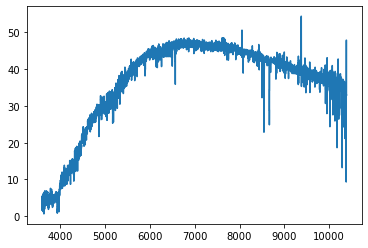

In [6]:
row = t[giants][0]
url = templ_spec_path.format(**{nm: row[nm] for nm in 'plate,mjd,fiberID'.split(',')})
fn = data.download_file(url, timeout=30)
brightspec = specutils.Spectrum1D.read(fn, format='SDSS-III/IV spec')

plt.step(brightspec.wavelength, brightspec.flux)
brightspec.radial_velocity = row['z']*cnst.c.to(u.km/u.s)
row['spectype'], brightspec.radial_velocity

In [7]:
row = t[giants][-2]
url = templ_spec_path.format(**{nm: row[nm] for nm in 'plate,mjd,fiberID'.split(',')})
fn = data.download_file(url, timeout=30)
faintspec = specutils.Spectrum1D.read(fn, format='SDSS-III/IV spec')

faintspec.radial_velocity = row['z']*cnst.c.to(u.km/u.s)
row['spectype'], faintspec.radial_velocity

('K2III', <Quantity -52.92302215 km / s>)

##  Template spectra

Use the Phoenix grids as the templates.  For example purposes we will just grab two, one that's about the right teff/logg for a K2III, and another more like a K4III:

In [8]:
# note these are very slow downloads, so just recording urls here and downloaded separately
templ_logg2p5_teff5200_url = 'http://osubdd.ens-lyon.fr/phoenix/phoenix.cgi?c=i&a=mime:application/fits&o=phoenix:Grids/BT-Settl/CIFIST2011_2015/SPECTRA/lte052.0-2.5-0.0a+0.0.BT-Settl.spec.7.xz'
templ_logg2p5_teff4600_url = 'http://osubdd.ens-lyon.fr/phoenix/phoenix.cgi?c=i&a=mime:application/fits&o=phoenix:Grids/BT-Settl/CIFIST2011_2015/SPECTRA/lte046.0-2.5-0.0a+0.0.BT-Settl.spec.7.xz'

In [9]:
f46 = fits.open('phoenix_Grids_BT-Settl_CIFIST2011_2015_SPECTRA_lte046.0-2.5-0.0a 0.0.BT-Settl.spec.7.xz.fits')
templ_spec4600 = specutils.Spectrum1D(spectral_axis=f46[1].data['WAVELENGTH']*u.angstrom, 
                                      flux=f46[1].data['FLUX']*u.angstrom)

In [10]:
f52 = fits.open('phoenix_Grids_BT-Settl_CIFIST2011_2015_SPECTRA_lte052.0-2.5-0.0a 0.0.BT-Settl.spec.7.xz.fits')
templ_spec5200 = specutils.Spectrum1D(spectral_axis=f52[1].data['WAVELENGTH']*u.angstrom, 
                                      flux=f52[1].data['FLUX']*u.angstrom)

(8000, 9000)

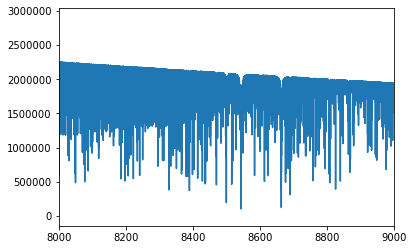

In [11]:
plt.step(templ_spec4600.wavelength, templ_spec4600.flux)
plt.xlim(8000, 9000)

Very different resolution... but lets see what happens:

In [12]:
from specutils.analysis.correlation import template_correlate # this should be from analysis not correlation

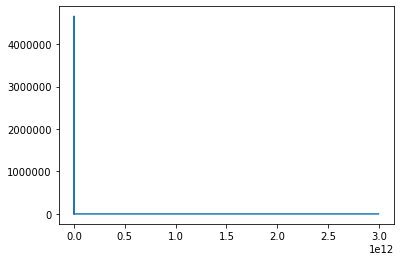

In [14]:
corr, lags = template_correlate(brightspec, templ_spec5200)
plt.plot(lags, corr)

Hmmm.  Does not auto re-sample just as the docs say. Need to resample, but should smooth the template *first* to something slightly higher-res than the observed spectra.

## Smoothing and re-sampling to a common grid 

First lets figure out how much to smooth the template to match the data

In [16]:
#overlap_region = specutils.SpectralRegion(brightspec.spectral_axis.min(), brightspec.spectral_axis.max())
#res = manipulation.extract_region(templ_spec5200, overlap_region)  # <--- this is slow and shouldn't be!

In [17]:
overlap_msk = (brightspec.spectral_axis.min() < templ_spec5200.spectral_axis) & (templ_spec5200.spectral_axis < brightspec.spectral_axis.max())
templ_scale = np.median(np.diff(templ_spec5200.spectral_axis[overlap_msk]))/u.pixel
np.unique(np.diff(templ_spec5200.spectral_axis[overlap_msk])), templ_scale

(<Quantity [0.02, 0.02, 0.02, 0.02] Angstrom>, <Quantity 0.02 Angstrom / pix>)

Nearly-uniform spacing over the whole templare region of interest.  So we can use that to compute the pixel-box needed. What about the data?

<Quantity 1.40722656 Angstrom>

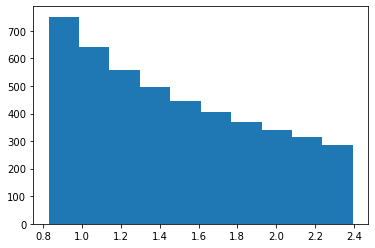

In [18]:
dlamb = np.diff(brightspec.spectral_axis)
plt.hist(dlamb.value)
np.median(dlamb)

Aha it's already a log-spaced axis. Smooth to just the median dlamb then:

(8000, 9000)

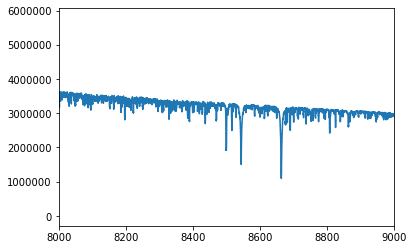

In [19]:
box_size = (np.median(dlamb)/templ_scale).value
smoothed_templ = manipulation.box_smooth(templ_spec5200, box_size)
plt.step(smoothed_templ.wavelength, smoothed_templ.flux)
plt.xlim(8000, 9000)

(8000, 9000)

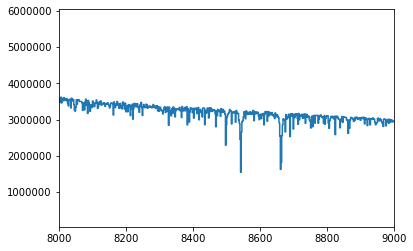

In [20]:
smoothed_resampled_templ = manipulation.LinearInterpolatedResampler()(smoothed_templ, brightspec.spectral_axis)
plt.step(smoothed_resampled_templ.wavelength, smoothed_resampled_templ.flux)
plt.xlim(8000, 9000)

Now we can cross-correlate:

/Users/erik/miniconda3/envs/astro38/lib/python3.8/site-packages/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


<Quantity 24095.17027309 km / s>

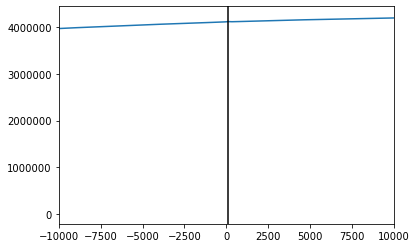

In [21]:
corr, lags = template_correlate(brightspec, smoothed_resampled_templ)
plt.plot(lags, corr)
plt.axvline(brightspec.radial_velocity.value,c = 'k')
plt.xlim(-10000, 10000)
lags[np.argmax(corr)]

Uh oh... the lags are not sampled finely enough, probably because it's only once per pixel. So maybe try switching to a much higher-resolution re-binning?

Also the docs do not see resampling is happening internally.  That's a problem...

In [22]:
resampler = manipulation.LinearInterpolatedResampler('zero_fill')

new_spectral_axis = np.geomspace(np.min(brightspec.spectral_axis), 
                                 np.max(brightspec.spectral_axis), 
                                 brightspec.spectral_axis.shape[0]*2)

brightspec_resampled = resampler(brightspec, new_spectral_axis)

smoothed_templ = manipulation.box_smooth(templ_spec5200, box_size)
smoothed_resampled_templ = resampler(smoothed_templ, new_spectral_axis)

<Quantity 22735.42152464 km / s>

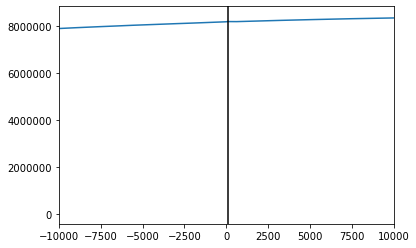

In [23]:
corr, lags = template_correlate(brightspec_resampled, smoothed_resampled_templ)
plt.plot(lags, corr)
plt.axvline(brightspec.radial_velocity.value,c = 'k')
plt.xlim(-10000, 10000)
lags[np.argmax(corr)]

Why doesn't that work??  Oh.  It's probably the internal resampler, so there needs to be some way to work around that.

## Add continuum normalization 

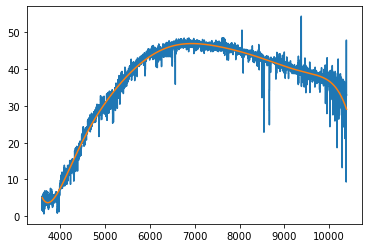

In [24]:
cont = fitting.fit_generic_continuum(brightspec, model=models.Chebyshev1D(10))
plt.step(brightspec.wavelength, brightspec.flux)

plt.plot(brightspec.wavelength, cont(brightspec.wavelength))

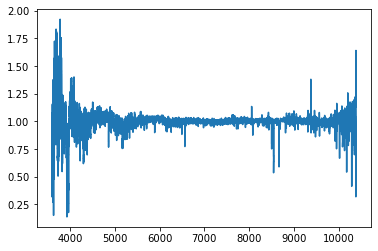

In [25]:
brightspec_contnorm = brightspec/cont(brightspec.wavelength)
plt.step(brightspec_contnorm.wavelength, brightspec_contnorm.flux);

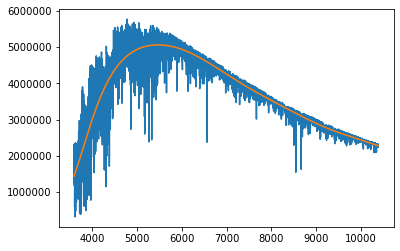

In [26]:
smoothed_templ = manipulation.box_smooth(templ_spec5200, box_size)
smoothed_resampled_templ = manipulation.LinearInterpolatedResampler()(smoothed_templ, brightspec.spectral_axis)

cont_templ = fitting.fit_generic_continuum(smoothed_resampled_templ, model=models.Chebyshev1D(10))

plt.step(smoothed_resampled_templ.wavelength, smoothed_resampled_templ.flux)
plt.plot(smoothed_resampled_templ.wavelength, cont_templ(smoothed_resampled_templ.wavelength))

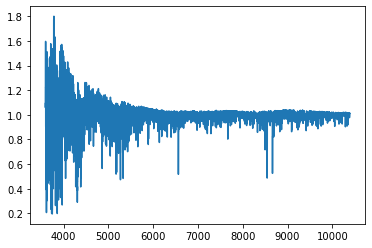

In [27]:
templ_contnorm = smoothed_resampled_templ/cont_templ(smoothed_resampled_templ.wavelength)
plt.step(templ_contnorm.wavelength, templ_contnorm.flux);

(<Quantity 68.77885564 km / s>, <Quantity 87.08272388 km / s>)

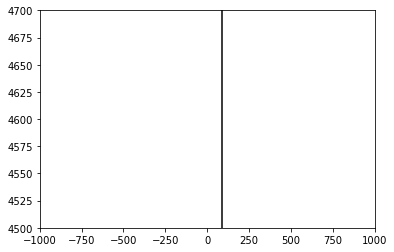

In [28]:
corr, lags = template_correlate(brightspec_contnorm, templ_contnorm)
plt.plot(lags, corr, 'o-')
plt.axvline(brightspec.radial_velocity.value,c='k')
plt.xlim(-1000, 1000)
plt.ylim(4500, 4700)
lags[np.argmax(corr)], brightspec.radial_velocity

Huzzah!  The peak is in about the right place now that we've added continuum normalization.  But it's still not quite right, and the reason is clear in the above plot: this can only manage whatever the native resolution is of the spectrum is, and as the example above ( The cell that ends in "Why doesn't that work??") shows, that's not working.

Can also try statistically estimating the peak a bit?:

<Quantity 84.64267908 km / s>

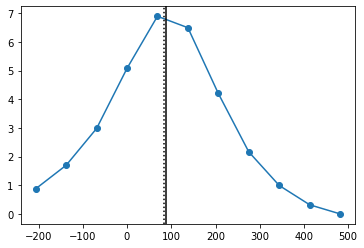

In [35]:
peak_msk = (-250*u.km/u.s<lags)&(lags<500*u.km/u.s)

corrlags = lags[peak_msk]
corrpeak = corr[peak_msk]-np.min(corr[peak_msk])

plt.plot(corrlags, corrpeak, 'o-')
centroid_corr = np.sum(corrlags*corrpeak/np.sum(corrpeak))
plt.axvline(centroid_corr.value, c='k', ls=':')
plt.axvline(brightspec.radial_velocity.value, c='k')
centroid_corr

That result depends on choosing parameters carefully for how you locate the peak but it's a proof-of-concept that it's plausible...

Still missing from this workflow: 

* limited set of lags (requires update to PR)